# Import needed libraries

In [15]:
# for dataset loading
import pandas as pd

# to visualize the molecules
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdmolops
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs

# for progress bars
from tqdm import tqdm, trange

# for figures
import matplotlib
from matplotlib import pyplot as plt

# for numerical operations
import numpy as np

# Load the compounds from csv

In [6]:
table=pd.read_csv("EGFR_compounds_lipinski.csv", sep=',')
table

,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...,...
4630,5562,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,5563,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,5564,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,5565,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


From this table, we need the SMILES strings and pIC50, so columns 4 & 5.

In [8]:
needed_info=table.iloc[:,[4,5]]
needed_info

,smiles,pIC50
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
...,...,...
4630,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027
4631,O=C(O)/C=C/c1ccc(O)cc1,2.522879
4632,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030
4633,N#CC(C#N)Cc1ccc(O)cc1,2.187087


# Analyze the pIC50 distribution
Is some data over represented? Will we need to unbias it?<br>
As the task is to distinduish compounds with pIC50>8, we can approach this as a binary classification problem: active vs inactive compounds.

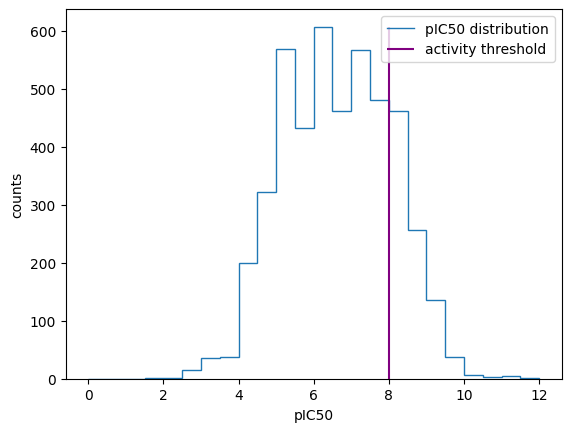

In [22]:
pIC50 = needed_info["pIC50"].values

# build a histogram
counts, bins = np.histogram(pIC50, range=(0,12), bins=12*2)
plt.stairs(counts, bins, label="pIC50 distribution")

# draw criterion for clasification as an active compound (pIC50=8)
plt.vlines(x = 8, ymin = 0, ymax = max(counts),
           colors = 'purple',
           label = 'activity threshold')

plt.xlabel("pIC50")
plt.ylabel("counts")
plt.legend()

plt.show()

In [25]:
actives = pIC50[pIC50>8]
print(f"{len(actives)*100./len(pIC50): .2f}% of compounds are active.")

 18.83% of compounds are active.


Yes, we have a lot fewer active compounds then inactives. Will need to try unbiasing.